# Final Report Data 695

## M5 Forecasting - Accuracy

### Estimating the unit sales of Walmart retail goods

The report contains a combination of multiple notebooks which have been a part of the submission

### Dataset

The dataset consists of five .csv files.

1. sales_train_validation.csv
    This is the main historical data file.

    Content: Contains the historical daily unit sales data for each unique item and store combination.

    Format: The data is in a wide format, with columns for the item and store IDs, followed by 1,913 columns (d_1 to d_1913) representing the daily unit sales from 2011-01-29 to 2016-04-24.

    Identifiers: Includes columns for item_id, dept_id, cat_id, store_id, and state_id.

2. sales_train_evaluation.csv
    This file was released later in the competition.

    Content: An extended version of sales_train_validation.csv.

    Format: It includes the sales data up to day d_1941 (2016-05-22), which covers the period used for the public leaderboard (validation set ground truth).

3. calendar.csv
    This file provides key time-related explanatory variables.

    Content: Maps the date (date) to the day of sale identifier (d_1, d_2, etc.) and includes exogenous features (external factors) that can affect sales.

    Includes information such as:

    Day of the week (weekday), month, year

    Various event types (event_name_1, event_type_1, etc.) such as holidays (e.g., Super Bowl, Easter)

    SNAP Food Stamp eligibility dates (for specific states)

4. sell_prices.csv
    This file tracks the pricing information for all items.

    Content: Contains the price of the products sold per store and week. Prices could change over time.

    Identifiers: Links to the sales data via store_id, item_id, and a time-related identifier (e.g., wm_yr_wk - week of the year).

5. sample_submission.csv
    This file defines the required output format for the final predictions.

    Content: Shows the required structure for the submission file.

    Format: Each row is an ID corresponding to one of the hierarchical time series (e.g., HOBBIES_1_001_CA_1_validation or HOBBIES_1_001_CA_1_evaluation), followed by 28 columns (F1 through F28) for the forecast days.

The goal of the competition is to predict sales from day 1942 to 1969
- The rows [d_1942 - d_1969] -> Evaluation set
- The rows [d_1914 - d_1941] -> Validation set 
- The rows [d_1 to d_1913] -> Train set

The accuracy competition will use the metric: Weighted Root Mean Squared Scaled Error (RMSSE)

The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details

In addition, it has explanatory variables such as price, promotions, day of the week, and special events.

### EDA + Feature Engineering

In [2]:
%pip install -q pandas
%pip install -q numpy
%pip install -q matplotlib
%pip install -q seaborn
%pip install -q lightgbm
%pip install -q tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt 
import seaborn as sns
from itertools import cycle
import lightgbm as lgb
import gc
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

C:\Users\gauth\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Due to the larger size of the dataset it is necessary to adjust the size of the data types to load it to memory

In [4]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int64)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32) 
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif 'object' in str(t):
            if cols[i] != 'date':
                df[cols[i]] = df[cols[i]].astype('category')
    return df



The function iterates through every column in the input DataFrame and applies a memory-saving conversion based on the column's current data type.

If the column contains integers convert them to int32 ot int64 depending on the min and max values.

If the column contains floats convert them to float32 ot float64 depending on the min and max values.

If the column contains objects, excluding dates, treat them as categorical variables for the model to use.

Reading the datasets:

In [5]:
calendar = pd.read_csv("Dataset\calendar.csv")
prices = pd.read_csv("Dataset\sell_prices.csv")
sales = pd.read_csv("Dataset\sales_train_validation.csv")
ss= pd.read_csv("Dataset\sample_submission.csv")

calendar = downcast(calendar)
prices = downcast(prices)
sales = downcast(sales)
ss = downcast(ss)
print("Data loaded and downcasted")     

Data loaded and downcasted


In [6]:
ss.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


Visualizing random/highest selling products

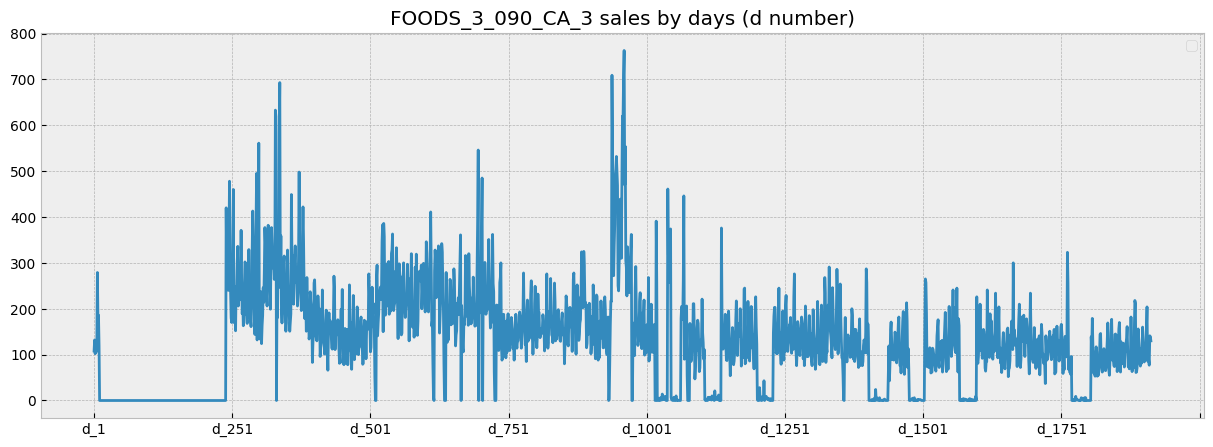

In [8]:
d_cols = [c for c in sales.columns if 'd_' in c]
sales.loc[sales['id'] == "FOODS_3_090_CA_3_validation"].set_index('id')[d_cols].T.plot(figsize = (15,5),title = 'FOODS_3_090_CA_3 sales by days (d number)',
                                                                                  color = next(color_cycle))
plt.legend("")
plt.show()

In [9]:
calendar[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


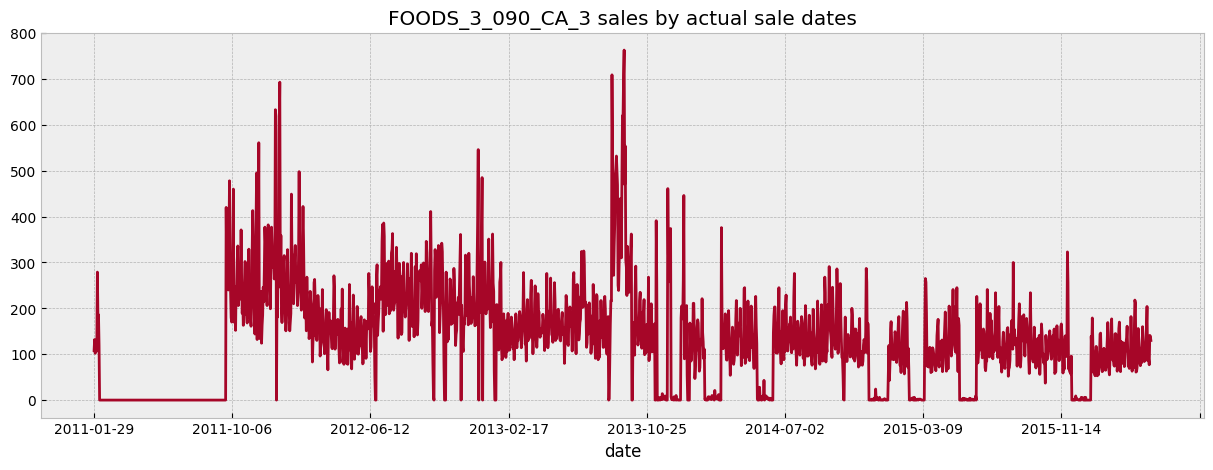

In [10]:
example = sales.loc[sales['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns = {8412: 'FOODS_3_090_CA_3'})
example = example.reset_index().rename(columns = {'index' : 'd'})

example = example.merge(calendar, how = 'left', validate = '1:1')
example.set_index('date')['FOODS_3_090_CA_3'].plot(figsize = (15,5), color = next(color_cycle), title = 'FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

example2 = sales.loc[sales['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) 
example2 = example2.reset_index().rename(columns={'index': 'd'}) 
example2 = example2.merge(calendar, how='left', validate='1:1')

example3 = sales.loc[sales['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'})
example3 = example3.reset_index().rename(columns={'index': 'd'}) 
example3 = example3.merge(calendar, how='left', validate='1:1')



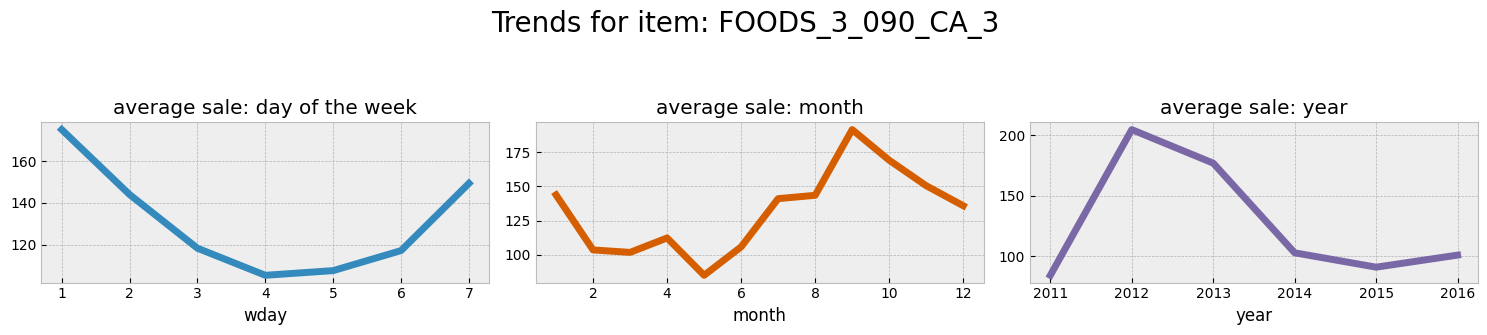

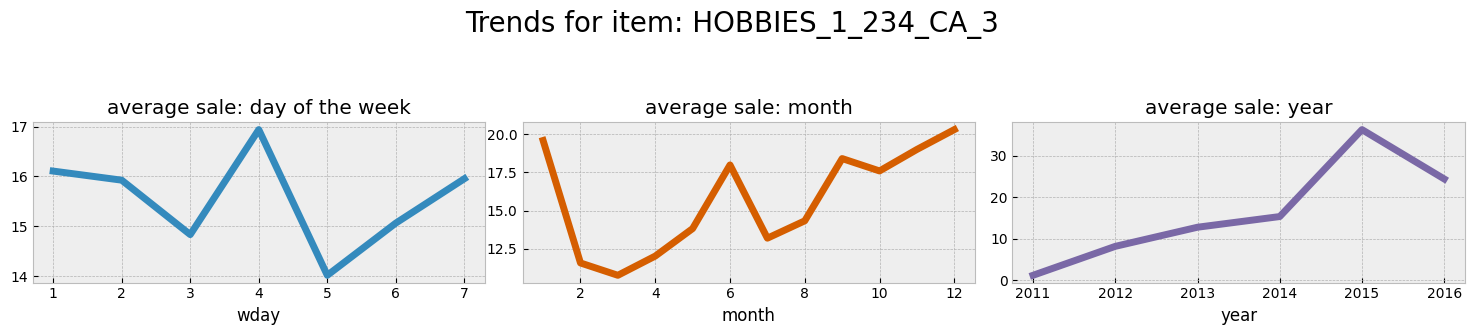

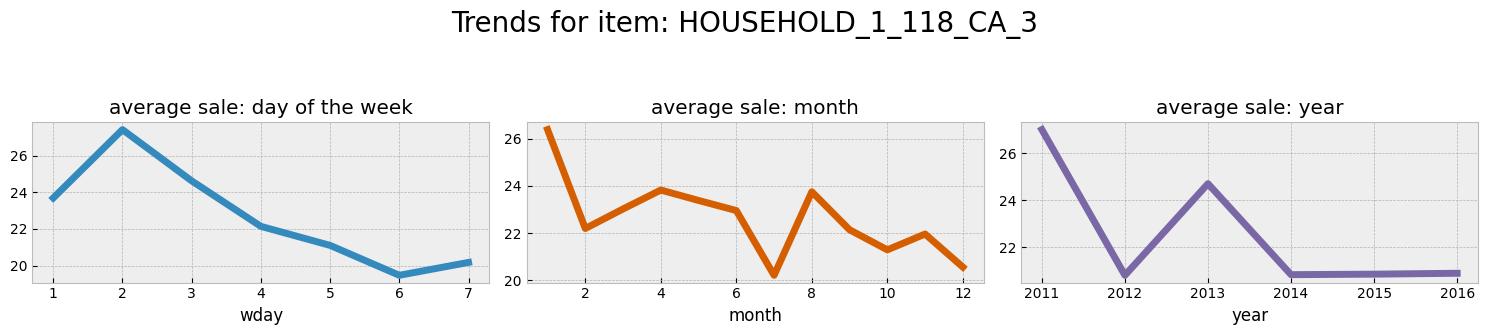

In [11]:
examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
example_df = [example, example2, example3]

for i in [0, 1, 2]:
    df = example_df[i]
    sales_col = examples[i]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
        
    # Day of Week
    df.groupby('wday')[sales_col].mean().plot(
        kind='line', 
        title='average sale: day of the week', 
        lw=5, 
        color=color_pal[0], 
        ax=ax1
    )
    
    # Month
    df.groupby('month')[sales_col].mean().plot(
        kind='line', 
        title='average sale: month', 
        lw=5, 
        color=color_pal[4], 
        ax=ax2
    )

    # Year
    df.groupby('year')[sales_col].mean().plot(
        kind='line', 
        title='average sale: year', 
        lw=5, 
        color=color_pal[2], 
        ax=ax3
    )

    fig.suptitle(f"Trends for item: {sales_col}", size=20, y=1.1)
    plt.tight_layout()
    plt.show()


In [12]:
sales['cat_id'].unique()

['HOBBIES', 'HOUSEHOLD', 'FOODS']
Categories (3, object): ['FOODS', 'HOBBIES', 'HOUSEHOLD']

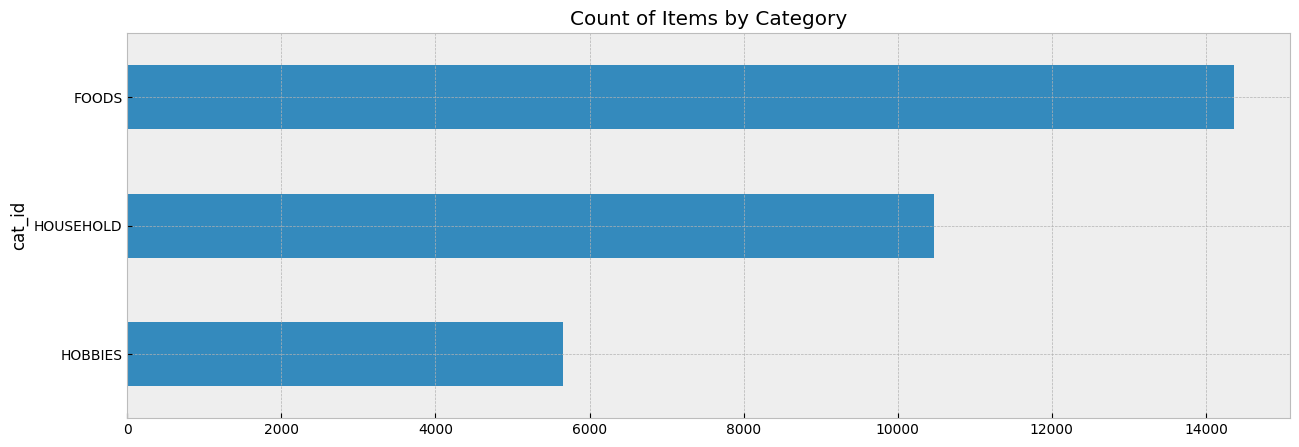

In [13]:
sales.groupby('cat_id').count()['id'].sort_values().plot(kind = 'barh', figsize = (15,5), title = 'Count of Items by Category')
plt.show()

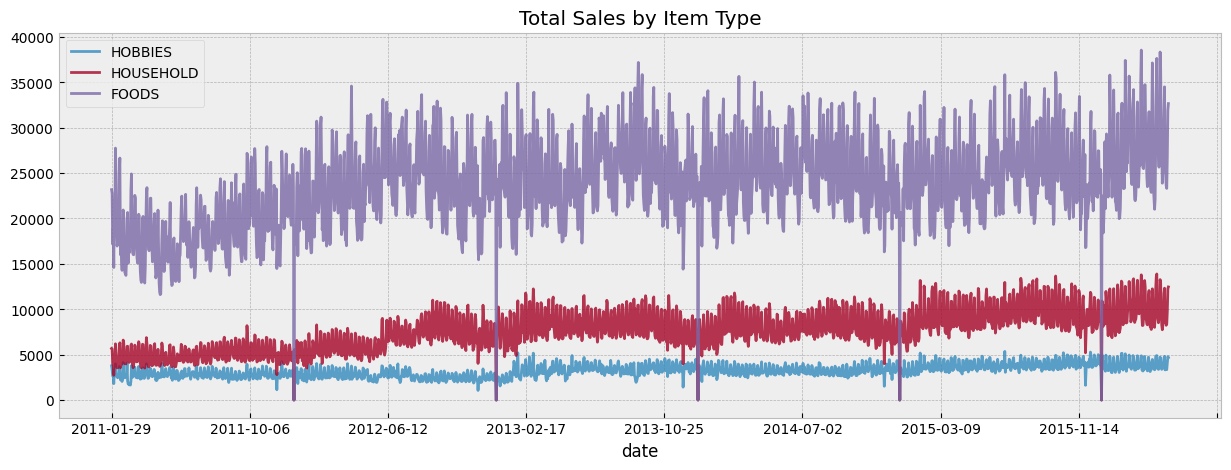

In [14]:
past_sales = sales.set_index('id')[d_cols] \
    .T \
    .reset_index() \
    .rename(columns={'index': 'd'}) \
    .merge(calendar[['d', 'date']],
           on='d', 
           how='left',
           validate='1:1') \
    .set_index('date') \
    .drop(columns='d')

for i in sales['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis = 1).plot(figsize = (15,5), alpha = 0.8, title = 'Total Sales by Item Type')

plt.legend(sales['cat_id'].unique())
plt.show()

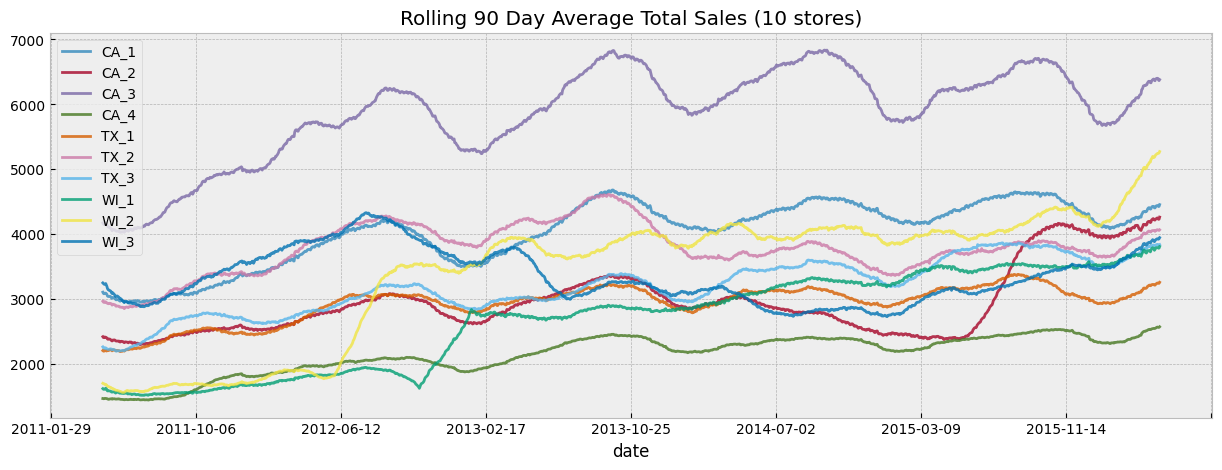

In [15]:
store_list = sales['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

There are patterns of seasonality by looking at the rolling average sales for 90 days by store. A weekly plot can help better visualize the patterns.

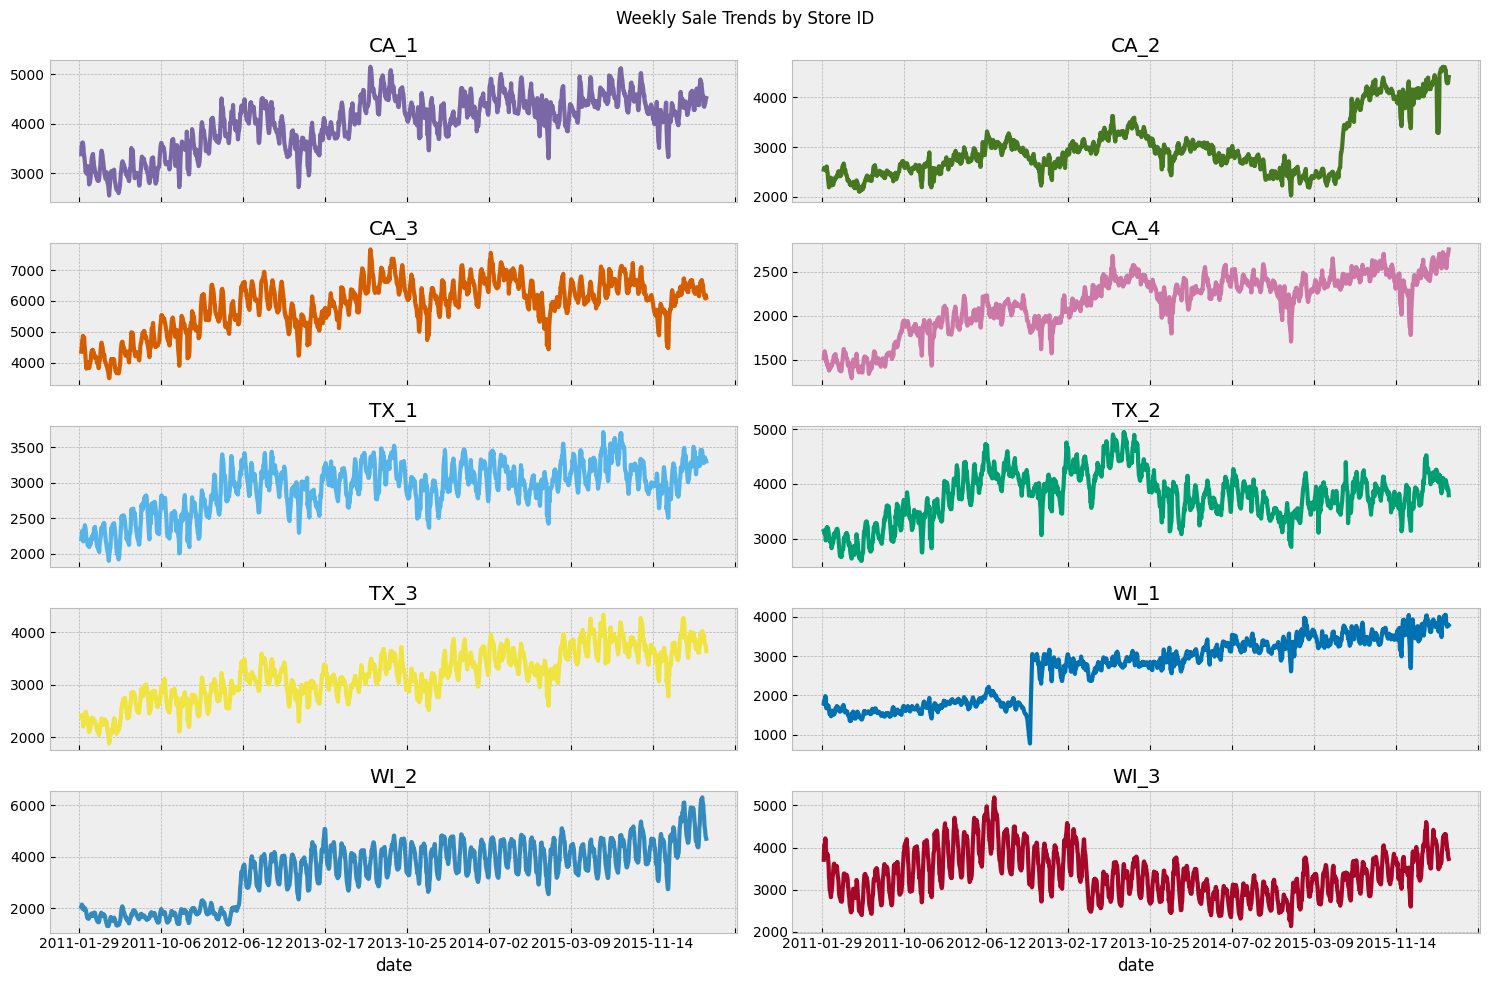

In [16]:
fig, axes = plt.subplots(5,2, figsize = (15,10), sharex = True)
axes = axes.flatten()
ax_idx = 0

for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
    .sum(axis = 1) \
    .rolling(7).mean() \
    .plot(alpha = 1, ax = axes[ax_idx], title = s, lw = 3, color = next(color_cycle))
    ax_idx += 1

plt.suptitle('Weekly Sale Trends by Store ID')
plt.tight_layout()
plt.show()    


Feature Extraction

In [18]:
df = pd.melt(sales, id_vars= ['id', 'item_id', 'dept_id',
                             'cat_id', 'store_id', 'state_id'],
                             var_name= 'd' , value_name= 'sales')

for col in ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']:
    df[col] = df[col].copy().astype('category')

df = pd.merge(df, calendar, on = 'd', how = 'left')
df = pd.merge(df, prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
gc.collect()

df['d'] = df['d'].str.extract(r'(\d+)').astype(np.int16)
df['wday'] = df['wday'].astype(np.int8)
df['month'] = df['month'].astype(np.int8)
df['year'] = df['year'].astype(np.int16)

item_id_freq_map = df['item_id'].value_counts().to_dict()
df['item_id_freq'] = df['item_id'].map(item_id_freq_map).astype(np.int32)

windows = [7, 14, 28]
for window in tqdm(windows, desc = "Creating Rolling Means"):
    df[f'rolling_mean_{window}'] = df.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(window).mean()).astype(np.float32)
gc.collect()


Creating Rolling Means: 100%|██████████| 3/3 [01:53<00:00, 37.71s/it]


14